# Packages

In [1]:
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow import keras
from scipy.stats import norm
from keras.layers import Input, Dense, Concatenate, BatchNormalization
from keras.models import Model
from keras import backend as kb
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
plt.style.use('ggplot')
%run Fourier.ipynb # Imports some functions: Heston greeks and L(t,v)
%run Neural_Networks.ipynb # Imports Neural Network
%run Simulation.ipynb # Imports the function to simulate from the Heston model

# Parameters

In [2]:
# Model parameters 
S0 = 100
K = 100
V0 = 0.2**2
mu = 0.1
sigma = 0.3
kappa = 1
theta = 0.2**2
rho = -0.7
r = 0.05
T = 30/365

# Proportional transaction costs
prop = 0.01

# Simulation parameters
steps = 30
dt = T/steps
n_train = 100000
n_test = 10000
#simulation_method = "full truncation" # Choose either "full truncation" or "moment matching"


# Neural Network parameters
epochs = 20
learn_rate = 0.001
batch_size = 100
neurons = 200 # Number of neurons in hidden layers
n_hidden_layers = 3 # Number of hidden layers
n_inputs = 3 # time, logS(t) and the volatility
n_outputs = 2 # delta1 and delta2

In [3]:
callprice = HestonFourier(spot=S0, timetoexp=T, strike=K, r=r, divyield=0, V=V0, theta=theta, kappa=kappa, sigma=sigma, rho=rho, greek=1)
print(callprice)

2.4859242733097773


In [4]:
time_grid = np.linspace(0,T,steps+1)

S1_train = np.load("S1_train.npy")
V_train = np.load("V_train.npy")
S2_train = np.cumsum(np.load("intV_train.npy"),axis=-1)+L(time_grid,V_train)

dS1_train = np.diff(S1_train,1,1)
dS2_train = np.diff(S2_train,1,1)

# Append the two lists alternatingly
dS_train = np.empty(shape=(n_train,2*steps))
dS_train[:,::2] = dS1_train
dS_train[:,1::2] = dS2_train

# Creates training input for NN
input_train = []

for i in range(steps):
    time_rep = np.repeat(time_grid[i],n_train)
    time_rep = np.reshape(time_rep,(n_train,1))
    S1_input_train = np.reshape(np.log(S1_train[:,i])-np.log(S0),(n_train,1))
    V_input_train = np.reshape(V_train[:,i]-V0,(n_train,1))
    input_train.append(np.concatenate((time_rep,S1_input_train,V_input_train),1))

In [5]:
# 3 terms: Price of a call option, the value of the hedge portfolio, the payoff of the call option
def value_pf(y_true,y_pred):
    S1 = S0
    S2 = L(0,V0)
    dS1 = y_true[:,::2]
    dS2 = y_true[:,1::2]
    delta1 = y_pred[:,::2]
    delta2 = y_pred[:,1::2]
    Vpf = callprice 
    B = Vpf - delta1[:,0]*S1*(1+prop)-delta2[:,0]*S2*(1+prop)
    for i in range(1,steps):
        S1 += dS1[:,i-1]
        S2 += dS2[:,i-1]
        Vpf = delta1[:,i-1]*S1+delta2[:,i-1]*S2+B*kb.exp(r*dt)
        tc = prop*S1*kb.abs(delta1[:,i]-delta1[:,i-1]) + prop*S2*kb.abs(delta2[:,i]-delta2[:,i-1])
        B = Vpf - delta1[:,i]*S1 - delta2[:,i]*S2 - tc
    S1 += dS1[:,-1]
    S2 += dS2[:,-1]
    Vpf = delta1[:,-1]*S1+delta2[:,-1]*S2+B*kb.exp(r*dt)
    return Vpf
        
def loss_call(y_true,y_pred):
    return (value_pf(y_true,y_pred) - kb.maximum(S0 + kb.sum(y_true[:,::2],axis=-1) - K,0.))**2

In [6]:
model = FFNN('linear',n_inputs,n_outputs,loss_call, learn_rate,neurons,n_hidden_layers)

In [7]:
#model.summary()

In [8]:
model.fit(input_train,dS_train,batch_size=batch_size,epochs=epochs)

Epoch 1/20
1000/1000 [==============================] - 23s 16ms/step - loss: 2.0235
Epoch 2/20
1000/1000 [==============================] - 18s 18ms/step - loss: 1.8625
Epoch 3/20
1000/1000 [==============================] - 16s 16ms/step - loss: 1.8383 0s - loss: 1. - ETA: 0s - loss: 1.8
Epoch 4/20
1000/1000 [==============================] - 16s 16ms/step - loss: 1.8281
Epoch 5/20
1000/1000 [==============================] - 17s 17ms/step - loss: 1.7884
Epoch 6/20
1000/1000 [==============================] - 18s 18ms/step - loss: 1.5812
Epoch 7/20
1000/1000 [==============================] - 18s 18ms/step - loss: 1.3009
Epoch 8/20
1000/1000 [==============================] - 19s 19ms/step - loss: 1.1154 0s 
Epoch 9/20
1000/1000 [==============================] - 19s 19ms/step - loss: 0.9506
Epoch 10/20
1000/1000 [==============================] - 20s 20ms/step - loss: 0.9002
Epoch 11/20
1000/1000 [==============================] - 18s 18ms/step - loss: 0.9273
Epoch 12/20
1000/1000 [

In [9]:
model.save('Heston simple TC')
#model = tf.keras.models.load_model('Heston simple TC', compile=False)

INFO:tensorflow:Assets written to: Heston simple TC\assets


In [24]:
time = T/2
S1_disc = np.linspace(0.94*S0,1.06*S0,num=steps)
V_disc = np.linspace(0.02,0.14,num=steps)

S1_grid, V_grid = np.meshgrid(S1_disc,V_disc)

delta1_NN = []
delta2_NN = []

for i in range(steps):
    input_plot = []
    for j in range(steps):
        input_plot.append(np.reshape((time,np.log(S1_grid[i,j])-np.log(S0),V_grid[i,j]-V0),(1,3)))
    delta1_NN.append(np.reshape(model.predict(input_plot),(steps*2,))[::2])
    delta2_NN.append(np.reshape(model.predict(input_plot),(steps*2,))[1::2])

delta1_NN = np.array(delta1_NN)
delta2_NN = np.array(delta2_NN)

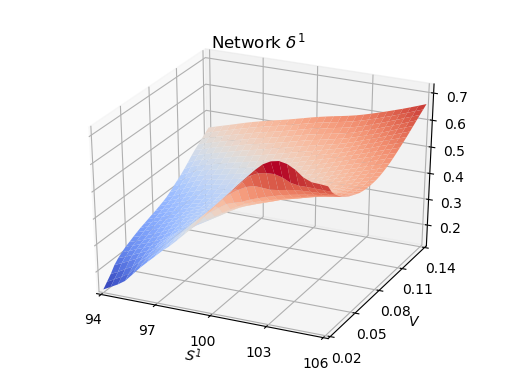

In [25]:
with plt.style.context(['default']):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(S1_grid, V_grid, delta1_NN, cmap=cm.coolwarm,linewidth=0)
    ax.set_xlabel('$S^1$')
    ax.set_ylabel('$V$')
    ax.ticklabel_format(useOffset=False)
    ax.set_title("Network $\delta^1$", y=0.95)
    ax.set_xticks([94, 97, 100, 103, 106])
    ax.set_yticks([0.02, 0.05, 0.08, 0.11, 0.14])
    ax.set_xlim(106, 94)
    ax.set_ylim(0.14,0.02)
    ax.view_init(30, 115)
    ax.dist = 11
    
#plt.savefig("Hestondelta1_NN_4hl200n10e.png", dpi=500,bbox_inches="tight")
plt.show()

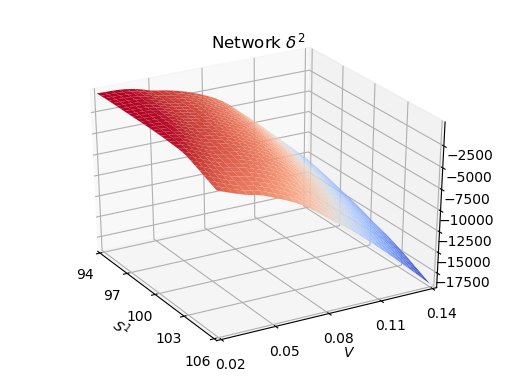

In [26]:
with plt.style.context(['default']):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(S1_grid,V_grid, delta2_NN, cmap=cm.coolwarm,linewidth=0)
    ax.set_xlabel('$S^1$')
    ax.set_ylabel('$V$')
    ax.set_title("Network $\delta^2$", y=0.95)
    ax.ticklabel_format(useOffset=False)
    ax.set_xticks([94, 97, 100, 103, 106])
    ax.set_yticks([0.02, 0.05, 0.08, 0.11, 0.14])
    #ax.set_zticks([0.2, 0.4, 0.6, 0.8])
    ax.set_xlim(106, 94)
    ax.set_ylim(0.14,0.02)
    ax.view_init(30, 150)
    ax.dist = 11
    
#plt.savefig("Hestondelta2_NN_4hl200n10e.png", dpi=500,bbox_inches="tight")
plt.show()

In [27]:
delta1_m = vdelta1(S1_grid,V_grid,time)  
delta2_m = vdelta2(S1_grid,V_grid,time)

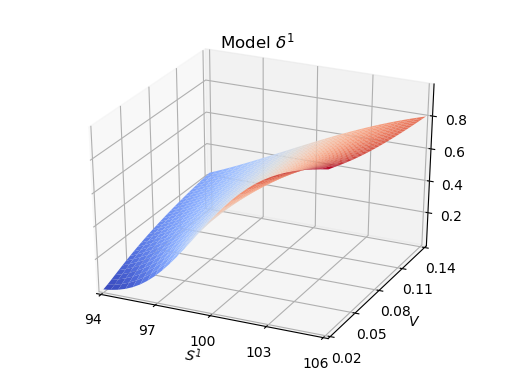

In [28]:
with plt.style.context(['default']):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(S1_grid, V_grid, delta1_m, cmap=cm.coolwarm,linewidth=0)
    ax.set_xlabel('$S^1$')
    ax.set_ylabel('$V$')
    #ax.set_zlabel('delta1')
    ax.set_title("Model $\delta^1$", y=0.95)
    ax.ticklabel_format(useOffset=False)
    ax.set_xticks([94, 97, 100, 103, 106])
    ax.set_yticks([0.02, 0.05, 0.08, 0.11, 0.14])
    ax.set_xlim(106, 94)
    ax.set_ylim(0.14,0.02)
    ax.view_init(30, 115)
    ax.dist = 11
    
#plt.savefig("Hestondelta1_m_3hl200n20e.png", dpi=500,bbox_inches="tight")
plt.show()

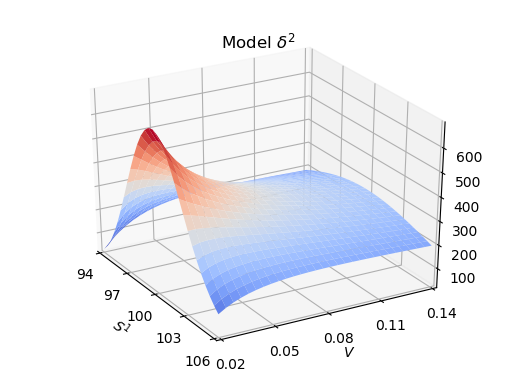

In [29]:
with plt.style.context(['default']):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(S1_grid, V_grid, delta2_m, cmap=cm.coolwarm,linewidth=0)
    ax.set_xlabel('$S^1$')
    ax.set_ylabel('$V$')
    ax.set_title("Model $\delta^2$", y=0.95)
    ax.ticklabel_format(useOffset=False)
    ax.set_xticks([94, 97, 100, 103, 106])
    ax.set_yticks([0.02, 0.05, 0.08, 0.11, 0.14])
    #ax.set_zticks([0.2, 0.4, 0.6, 0.8])
    ax.set_xlim(106, 94)
    ax.set_ylim(0.14,0.02)
    ax.view_init(30, 150)
    ax.dist = 11
    
#plt.savefig("Hestondelta2_m_3hl200n20e.png", dpi=500,bbox_inches="tight")
plt.show()

# Test

In [10]:
S1_test = np.load("S1_test.npy")
V_test = np.load("V_test.npy")
S2_test = np.cumsum(np.load("intV_test.npy"),axis=-1)+L(time_grid,V_test)

In [11]:
dS1_test = np.diff(S1_test,1,1)
dS2_test = np.diff(S2_test,1,1)

# Append the two lists alternatingly
dS_test = np.empty(shape=(n_test,2*steps))
dS_test[:,::2] = dS1_test
dS_test[:,1::2] = dS2_test

# Creates test input for NN
input_test = []

for i in range(steps):
    time_rep = np.repeat(time_grid[i],n_test)
    time_rep = np.reshape(time_rep,(n_test,1))
    S1_input_test = np.reshape(np.log(S1_test[:, i])-np.log(S0),(n_test,1))
    V_input_test = np.reshape(V_test[:,i]-V0,(n_test,1))
    input_test.append(np.concatenate((time_rep,S1_input_test,V_input_test),1))

In [12]:
delta_NN_test = model.predict(input_test)
delta1_NN_test = delta_NN_test[:,::2]
delta2_NN_test = delta_NN_test[:,1::2]

Vpf_NN = callprice
B = Vpf_NN - delta1_NN_test[:,0]*S1_test[:,0]*(1+prop)-delta2_NN_test[:,0]*S2_test[:,0]*(1+prop)
for i in range(1,steps):
    Vpf_NN = delta1_NN_test[:,i-1]*S1_test[:,i]+delta2_NN_test[:,i-1]*S2_test[:,i]+B*np.exp(r*dt)
    tc1 = np.abs(delta1_NN_test[:,i]-delta1_NN_test[:,i-1])*S1_test[:,i]*prop
    tc2 = np.abs(delta2_NN_test[:,i]-delta2_NN_test[:,i-1])*S2_test[:,i]*prop
    B = Vpf_NN - delta1_NN_test[:,i]*S1_test[:,i]-delta2_NN_test[:,i]*S2_test[:,i]-tc1-tc2
Vpf_NN = delta1_NN_test[:,-1]*S1_test[:,-1]+delta2_NN_test[:,-1]*S2_test[:,-1]+B*np.exp(r*dt)
Vpf_NN = np.array(Vpf_NN)

In [13]:
S1_grid2 = np.linspace(np.amin(S1_test[:,-1]),np.amax(S1_test[:,-1]),num=1000)
value_call_grid = np.maximum(S1_grid2-K,0)
value_call_true = np.maximum(S1_test[:,-1]-K,0)

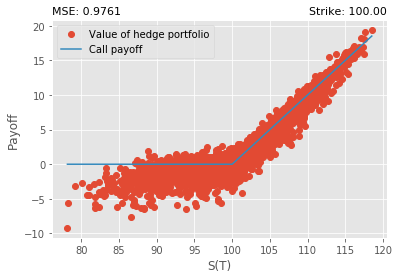

In [14]:
PnL_NN = Vpf_NN - value_call_true
MSE_NN = np.sum(PnL_NN**2)/n_test
hedge_NN    = plt.plot(S1_test[:,-1],Vpf_NN, 'o', label="Value of hedge portfolio")
line_call = plt.plot(S1_grid2,value_call_grid, label="Call payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
plt.title(r'Strike: %1.2f' % K, loc='right', fontsize=11)
plt.title(r'MSE: %1.4f' % MSE_NN, loc='left', fontsize=11)
plt.legend(loc='upper left')

plt.show()
#plt.savefig("HestonHedge_NN_4hl200n10e1kpaths.png", dpi=500,bbox_inches="tight")

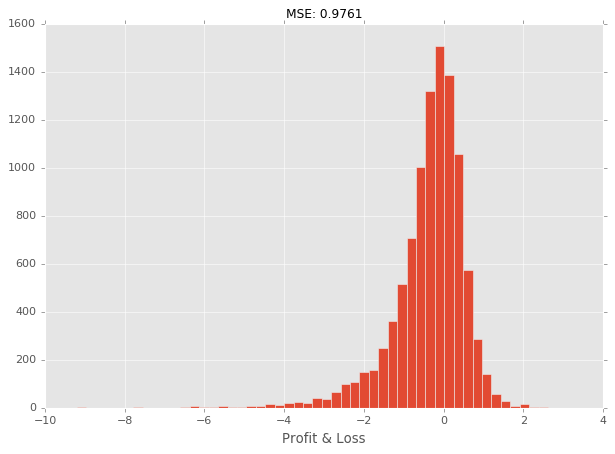

In [23]:
with plt.style.context(['classic', 'ggplot']):
    plt.figure(figsize=(9,6))
    plt.hist(PnL_NN,bins=50)
    plt.title(r'MSE: %1.4f' % MSE_NN, loc='center', fontsize=11)
    plt.xlabel("Profit & Loss")
    plt.ylim(0,1600)
plt.show()
#plt.savefig("HestonPnL_NN_4hl200n10e1kpaths.png", dpi=500,bbox_inches="tight")

# Comparison to hedging using model deltas

In [16]:
delta1_m_test = np.load('delta1_m_exact.npy')
delta2_m_test = np.load('delta2_m_exact.npy')

#delta1_m_exact = np.empty([n_test,steps])
#delta2_m_exact = np.empty([n_test,steps])
#
#for i in range(steps):
#    delta1_m_exact[:,i] = vdelta1(S1_test[:,i],V_test[:,i],i*dt)
#    delta2_m_exact[:,i] = vdelta2(S1_test[:,i],V_test[:,i],i*dt)
#    np.save('delta1_m_exact',delta1_m_exact)
#    np.save('delta2_m_exact',delta2_m_exact)
#    clear_output()
#    print(str(i+1)+' of '+str(steps)+' completed')
#print('Finished.')
#np.save('delta1_m_exact',delta1_m_exact)
#np.save('delta2_m_exact',delta2_m_exact)


In [17]:
Vpf_m = callprice
B = Vpf_m - delta1_m_test[:,0]*S1_test[:,0]*(1+prop)-delta2_m_test[:,0]*S2_test[:,0]*(1+prop)
for i in range(1,steps):
    Vpf_m = delta1_m_test[:,i-1]*S1_test[:,i]+delta2_m_test[:,i-1]*S2_test[:,i]+B*np.exp(r*dt)
    tc1 = np.abs(delta1_m_test[:,i]-delta1_m_test[:,i-1])*S1_test[:,i]*prop
    tc2 = np.abs(delta2_m_test[:,i]-delta2_m_test[:,i-1])*S2_test[:,i]*prop
    B = Vpf_m - delta1_m_test[:,i]*S1_test[:,i]-delta2_m_test[:,i]*S2_test[:,i] -tc1 -tc2
Vpf_m = delta1_m_test[:,-1]*S1_test[:,-1]+delta2_m_test[:,-1]*S2_test[:,-1]+B*np.exp(r*dt)

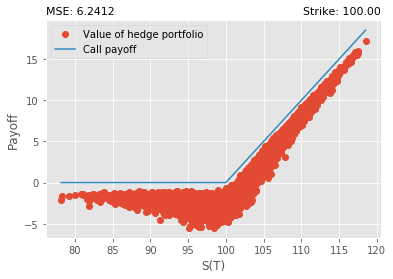

In [18]:
PnL_m = Vpf_m - value_call_true
MSE_m = np.sum(PnL_m**2)/n_test
hedge_m = plt.plot(S1_test[:,-1],Vpf_m, 'o', label="Value of hedge portfolio")
line_call = plt.plot(S1_grid2,value_call_grid, label="Call payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
plt.title(r'Strike: %1.2f' % K, loc='right', fontsize=11)
plt.title(r'MSE: %1.4f' % MSE_m, loc='left', fontsize=11)
plt.legend()

plt.show()
#plt.savefig("HestonHedge_m_4hl200n10e1kpaths.png", dpi=500,bbox_inches="tight")

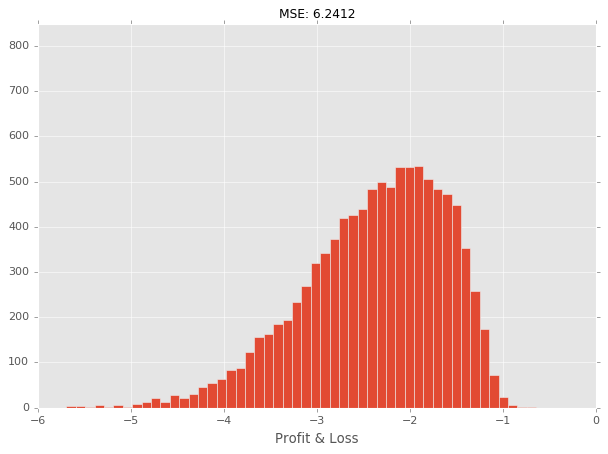

In [19]:
PnL_m = np.array(PnL_m)
with plt.style.context(['classic', 'ggplot']):
    plt.figure(figsize=(9,6))
    plt.hist(PnL_m, bins=50)
    plt.title(r'MSE: %1.4f' % MSE_m, loc='center', fontsize=11)
    plt.xlabel("Profit & Loss")
    plt.ylim(0,850)
plt.show()
#plt.savefig("HestonPnL_m_4hl200n10e1kpaths.png", dpi=500,bbox_inches="tight")

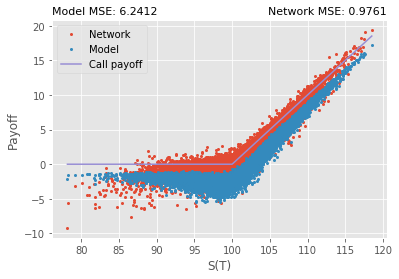

In [20]:
hedge_NN = plt.plot(S1_test[:,-1],Vpf_NN, 'o', label="Network",markersize=2)
hedge_m = plt.plot(S1_test[:,-1],Vpf_m, 'o', label="Model", markersize=2)
line_call = plt.plot(S1_grid2,value_call_grid, label="Call payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
plt.title(r'Model MSE: %1.4f' % MSE_m, loc='left', fontsize=11)
plt.title(r'Network MSE: %1.4f' % MSE_NN, loc='right', fontsize=11)
plt.legend(loc='upper left')

plt.show()
#plt.savefig("HestonHedge_simpleTC.png", dpi=500,bbox_inches="tight")

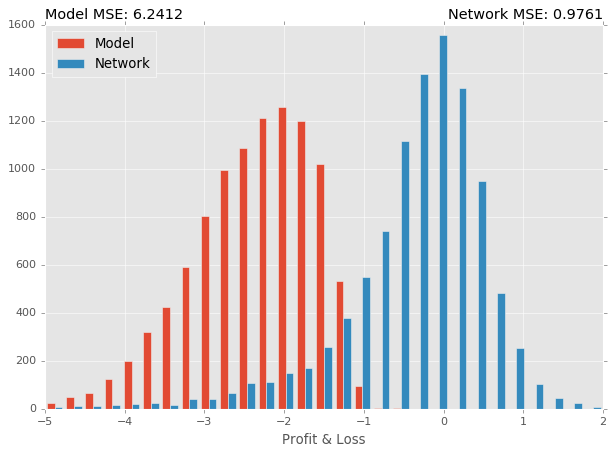

In [21]:
with plt.style.context(['classic','ggplot']):
    plt.figure(figsize=(9,6))
    bins = np.linspace(-5, 2, 30)
    plt.hist([PnL_m, PnL_NN], bins, label=['Model', 'Network'])
    plt.legend(loc='upper left')
    plt.xlabel("Profit & Loss")
    plt.title(r'Model MSE: %1.4f' % MSE_m, loc='left', fontsize=13)
    plt.title(r'Network MSE: %1.4f' % MSE_NN, loc='right', fontsize=13)
    plt.ylim(0, 1600)
plt.show()
#plt.savefig('Heston_PnL_simpleTC.png',dpi=500,bbox_inches="tight")